In [1]:
#Initialize Deep Learning Environment
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.device_count(), 'x', torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

2 x NVIDIA RTX A5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
# Import statements
import torch, detectron2
import pandas as pd
import segmentation_models_pytorch as smp

from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import ColorMode

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os, json, random, pickle
from IPython import display
import PIL

# Constant values
SEED = 0
THRESHOLD = 0.6

### Preperation

### Functions

In [3]:
def display_random_images(dataset_dict, dataset_metadata, n, image_scale = 1):
    """Pick n random images from the dataset and display them with bboxes.

    Args:
        dataset_dict: Get with DatasetCatalog.get("name_of_dataset")
        dataset_metadata: Get with MetadataCatalog.get("name_of_dataset")
        seed: For RNGs
        image_scale: Scale of images. Defaults to 1.
    """
    # Seed numpy RNG
    np.random.seed(SEED)
    # Pick a random image from the dataset
    picked_images = np.random.permutation(dataset_dict)[:n]
    
    for image in picked_images:
        # Get image link and id
        img_link = image['file_name']
        img_id = image['image_id']
        # Load image
        img = cv.imread(img_link)
        img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
        # Visualize image with box
        visualizer = Visualizer(img, metadata=dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(image)
        final_img = vis.get_image()
        # Display image
        plt.figure()
        plt.title('image id: ' + str(img_id))
        plt.axis('off')
        plt.imshow(final_img)

def read_metrics_from_json(metrics_path):
    """Read metrics from json file saved after training.

    Args:
        metrics_path (string): Path of the json file

    Returns:
        list: List of metrics
    """
    metrics = []
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    
    return metrics


def metric(metrics, specific_metric):
    """Get a specific metric from list of metrics returned from the
    read_metrics_from_json function.

    Args:
        metrics (list): List of metrics
        specific_metric (string): Name of the metric

    Returns:
        list: List of the specific metric
    """
    metric = []
    
    for i in range(len(metrics)):
        try: 
            metric.append(metrics[i][specific_metric])
        except KeyError:
            pass
    
    return metric


def create_predictions(dataset_dict, dataset_metadata, predictor, image_scale = 1):
    """Predict and display 3 random images from the dataset.

    Args:
        dataset_dict: Get with DatasetCatalog.get("name_of_dataset")
        dataset_metadata: Get with MetadataCatalog.get("name_of_dataset")
        image_scale: Scale of images. Defaults to 1.
    """
    # Seed numpy RNG
    np.random.seed(SEED)
    # Pick the 3 random images
    images = np.random.permutation(dataset_dict)[:3]
    # Prepare subplots
    fig, axs = plt.subplots(3,2, figsize = (20,20), dpi = 120)
    # Loop through images
    for i in range(3):
        # Draw original image
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv.imread(img_link)
        img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        # Draw predicted image
        visualizer2 = Visualizer(img[:, :, ::-1], metadata= dataset_metadata, scale=image_scale, instance_mode=ColorMode.IMAGE_BW)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv.cvtColor(out.get_image(), cv.COLOR_BGR2RGB)
        final_bbox = cv.cvtColor(out_img, cv.COLOR_BGR2RGB)
        # Plot the results
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 20)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 20, color = 'red')
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox[:, :, ::-1])
        
    fig.tight_layout()

### Example Data

WARNING [04/09 15:05:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 15:05:25 d2.data.datasets.coco]: Loaded 1502 images in COCO format from ./Dataset/train/_annotations.coco.json


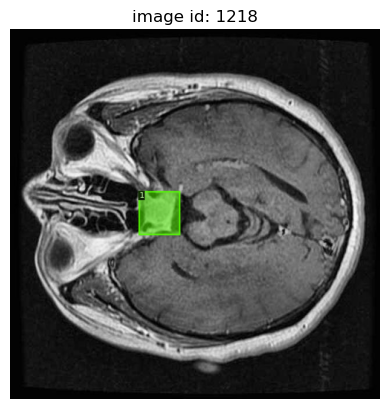

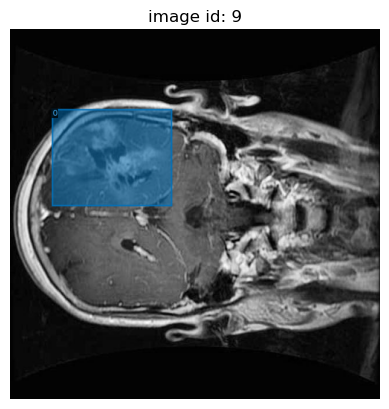

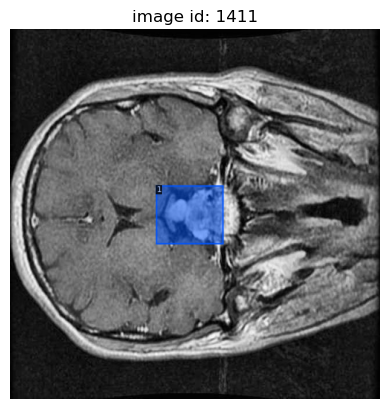

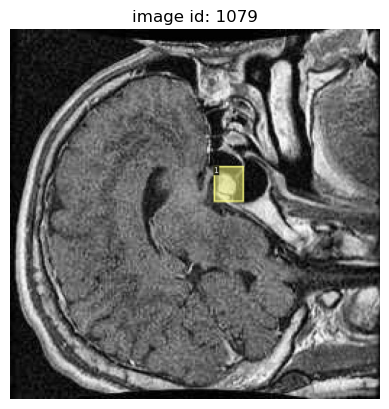

In [4]:
# Setup detectron2 logger
setup_logger()

# Load datasets as COCO instances
for set in ["train", "valid", "test"]:
    register_coco_instances(f"{set}_set", {},
                            f"./Dataset/{set}/_annotations.coco.json",
                            f"./Dataset/{set}")

# Get metadata and dataset_dicts
train_metadata = MetadataCatalog.get("train_set")
train_dicts = DatasetCatalog.get("train_set")

# Display 4 random images from the training dataset
display_random_images(train_dicts, train_metadata, 4)

## Preparation for CUDA Usage

## Function Definition for Training

In [5]:

def train_model(epochs, BASE_LR, NUM_CLASSES, transformations, BATCH_SIZE):
    from detectron2.data import transforms as T
    from detectron2.data import DatasetMapper  # Assuming this import is necessary for custom transformations
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("train_set",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
    cfg.SOLVER.BASE_LR = BASE_LR
    cfg.SOLVER.MAX_ITER = epochs
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # This is not the BATCH_SIZE for data loading, but related to the model's internal processing
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
    
    # Setup custom transformations if specified
    if 'Resize' in transformations:
        cfg.INPUT.MIN_SIZE_TRAIN = (800,)  # Example resize parameters, adjust as necessary
    if 'Flip' in transformations:
        cfg.INPUT.HORIZONTAL_FLIP_PROB_TRAIN = 0.5  # Example flip probability
    
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    # Placeholder for returning metrics, as Detectron2 handles most logging internally
    return {"status": "Completed", "EPOCHS": epochs, "BASE_LR": BASE_LR, "BATCH_SIZE": BATCH_SIZE, "TRANSFORMATIONS": transformations}


## Define Data Transformations

In [6]:

transformations = ["Resize", "Flip"]


## Iteration Over Hyperparameters

In [7]:
import itertools

# Defining hyperparameters
EPOCHS_OPTIONS = [1000, 2000, 3000]
BASE_LR_OPTIONS = [0.0001, 0.0005, 0.001]
TRANSFORMATIONS_OPTIONS = [['Resize', 'Flip'], ['Resize', 'Crop']]  
BATCH_SIZE_OPTIONS = [2, 4]  # Assuming Detectron2's batch size is configured here for simplicity

# Creating a grid of all possible hyperparameter combinations
hyperparameter_grid = list(itertools.product(EPOCHS_OPTIONS, BASE_LR_OPTIONS, TRANSFORMATIONS_OPTIONS, BATCH_SIZE_OPTIONS))

# Initializing the DataFrame for storing results
results_df = pd.DataFrame(columns=["EPOCHS", "BASE_LR", "TRANSFORMATIONS", "BATCH_SIZE", "METRIC"])

for epochs, lr, transformations, batch_size in hyperparameter_grid:
    # Simulating a training run with the current set of hyperparameters
    print(f"Training with EPOCHS={epochs}, BASE_LR={lr}, TRANSFORMATIONS={transformations}, BATCH_SIZE={batch_size}")
    metrics = train_model(epochs=epochs, BASE_LR=lr, NUM_CLASSES=3, transformations=transformations, BATCH_SIZE=batch_size)
    
    # Appending the results to the DataFrame
    new_row = {"EPOCHS": epochs, "BASE_LR": lr, "TRANSFORMATIONS": transformations, "BATCH_SIZE": batch_size, "METRIC": metrics['status']}
    new_row_df = pd.DataFrame([new_row])
results_df = pd.concat([results_df, new_row_df], ignore_index=True)

# Displaying the results DataFrame
print(results_df)


Training with EPOCHS=1000, BASE_LR=0.0001, TRANSFORMATIONS=['Resize', 'Flip'], BATCH_SIZE=2
[04/09 15:05:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:05:53 d2.engine.train_loop]: Starting training from iteration 0


/home/atesfet/anaconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/09 15:05:57 d2.utils.events]:  eta: 0:02:17  iter: 19  total_loss: 2.254  loss_cls: 1.432  loss_box_reg: 0.08504  loss_mask: 0.695  loss_rpn_cls: 0.02996  loss_rpn_loc: 0.006653    time: 0.1351  last_time: 0.1222  data_time: 0.0066  last_data_time: 0.0026   lr: 1.9981e-06  max_mem: 1767M
[04/09 15:06:00 d2.utils.events]:  eta: 0:02:11  iter: 39  total_loss: 2.194  loss_cls: 1.347  loss_box_reg: 0.06913  loss_mask: 0.6926  loss_rpn_cls: 0.06647  loss_rpn_loc: 0.01072    time: 0.1327  last_time: 0.1236  data_time: 0.0026  last_data_time: 0.0025   lr: 3.9961e-06  max_mem: 1768M
[04/09 15:06:03 d2.utils.events]:  eta: 0:01:56  iter: 59  total_loss: 2.019  loss_cls: 1.205  loss_box_reg: 0.06772  loss_mask: 0.6897  loss_rpn_cls: 0.02677  loss_rpn_loc: 0.007571    time: 0.1302  last_time: 0.1422  data_time: 0.0025  last_data_time: 0.0024   lr: 5.9941e-06  max_mem: 1768M
[04/09 15:06:05 d2.utils.events]:  eta: 0:01:54  iter: 79  total_loss: 1.816  loss_cls: 1.007  loss_box_reg: 0.08353  lo

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:08:05 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:08:10 d2.utils.events]:  eta: 0:03:51  iter: 19  total_loss: 2.065  loss_cls: 1.244  loss_box_reg: 0.08314  loss_mask: 0.6918  loss_rpn_cls: 0.0432  loss_rpn_loc: 0.00766    time: 0.2388  last_time: 0.2544  data_time: 0.0117  last_data_time: 0.0049   lr: 1.9981e-06  max_mem: 2698M
[04/09 15:08:15 d2.utils.events]:  eta: 0:03:47  iter: 39  total_loss: 1.998  loss_cls: 1.18  loss_box_reg: 0.08427  loss_mask: 0.69  loss_rpn_cls: 0.0328  loss_rpn_loc: 0.007107    time: 0.2388  last_time: 0.2350  data_time: 0.0058  last_data_time: 0.0052   lr: 3.9961e-06  max_mem: 2699M
[04/09 15:08:20 d2.utils.events]:  eta: 0:03:42  iter: 59  total_loss: 1.847  loss_cls: 1.038  loss_box_reg: 0.07574  loss_mask: 0.6867  loss_rpn_cls: 0.03516  loss_rpn_loc: 0.007569    time: 0.2412  last_time: 0.2331  data_time: 0.0050  last_data_time: 0.0048   lr: 5.9941e-06  max_mem: 2699M
[04/09 15:08:24 d2.utils.events]:  eta: 0:03:37  i

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:12:10 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:12:12 d2.utils.events]:  eta: 0:02:04  iter: 19  total_loss: 2.248  loss_cls: 1.417  loss_box_reg: 0.08554  loss_mask: 0.6922  loss_rpn_cls: 0.03648  loss_rpn_loc: 0.007276    time: 0.1268  last_time: 0.1270  data_time: 0.0073  last_data_time: 0.0026   lr: 1.9981e-06  max_mem: 2700M
[04/09 15:12:15 d2.utils.events]:  eta: 0:02:01  iter: 39  total_loss: 2.16  loss_cls: 1.34  loss_box_reg: 0.08411  loss_mask: 0.6905  loss_rpn_cls: 0.02494  loss_rpn_loc: 0.005955    time: 0.1268  last_time: 0.1243  data_time: 0.0026  last_data_time: 0.0025   lr: 3.9961e-06  max_mem: 2700M
[04/09 15:12:17 d2.utils.events]:  eta: 0:01:59  iter: 59  total_loss: 1.998  loss_cls: 1.195  loss_box_reg: 0.0779  loss_mask: 0.6881  loss_rpn_cls: 0.03169  loss_rpn_loc: 0.007226    time: 0.1269  last_time: 0.1253  data_time: 0.0026  last_data_time: 0.0026   lr: 5.9941e-06  max_mem: 2700M
[04/09 15:12:20 d2.utils.events]:  eta: 0:01:56

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:14:21 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:14:26 d2.utils.events]:  eta: 0:03:52  iter: 19  total_loss: 2.454  loss_cls: 1.622  loss_box_reg: 0.0865  loss_mask: 0.6925  loss_rpn_cls: 0.02913  loss_rpn_loc: 0.006349    time: 0.2379  last_time: 0.2387  data_time: 0.0112  last_data_time: 0.0084   lr: 1.9981e-06  max_mem: 2700M
[04/09 15:14:31 d2.utils.events]:  eta: 0:03:47  iter: 39  total_loss: 2.357  loss_cls: 1.537  loss_box_reg: 0.07984  loss_mask: 0.6907  loss_rpn_cls: 0.03423  loss_rpn_loc: 0.007804    time: 0.2379  last_time: 0.2374  data_time: 0.0056  last_data_time: 0.0051   lr: 3.9961e-06  max_mem: 2701M
[04/09 15:14:35 d2.utils.events]:  eta: 0:03:42  iter: 59  total_loss: 2.191  loss_cls: 1.358  loss_box_reg: 0.08096  loss_mask: 0.6877  loss_rpn_cls: 0.03675  loss_rpn_loc: 0.009041    time: 0.2376  last_time: 0.2349  data_time: 0.0049  last_data_time: 0.0045   lr: 5.9941e-06  max_mem: 2701M
[04/09 15:14:40 d2.utils.events]:  eta: 0:03:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:18:25 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:18:28 d2.utils.events]:  eta: 0:02:04  iter: 19  total_loss: 2.028  loss_cls: 1.215  loss_box_reg: 0.0724  loss_mask: 0.6915  loss_rpn_cls: 0.03302  loss_rpn_loc: 0.005919    time: 0.1267  last_time: 0.1253  data_time: 0.0072  last_data_time: 0.0026   lr: 9.9905e-06  max_mem: 2701M
[04/09 15:18:30 d2.utils.events]:  eta: 0:02:01  iter: 39  total_loss: 1.736  loss_cls: 0.9077  loss_box_reg: 0.06934  loss_mask: 0.6856  loss_rpn_cls: 0.03193  loss_rpn_loc: 0.007048    time: 0.1268  last_time: 0.1274  data_time: 0.0027  last_data_time: 0.0024   lr: 1.998e-05  max_mem: 2701M
[04/09 15:18:33 d2.utils.events]:  eta: 0:01:59  iter: 59  total_loss: 1.28  loss_cls: 0.4805  loss_box_reg: 0.08965  loss_mask: 0.6672  loss_rpn_cls: 0.03897  loss_rpn_loc: 0.005003    time: 0.1270  last_time: 0.1280  data_time: 0.0025  last_data_time: 0.0025   lr: 2.997e-05  max_mem: 2701M
[04/09 15:18:35 d2.utils.events]:  eta: 0:01:5

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:20:37 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:20:42 d2.utils.events]:  eta: 0:03:53  iter: 19  total_loss: 2.251  loss_cls: 1.434  loss_box_reg: 0.08881  loss_mask: 0.6918  loss_rpn_cls: 0.04027  loss_rpn_loc: 0.007383    time: 0.2379  last_time: 0.2379  data_time: 0.0108  last_data_time: 0.0053   lr: 9.9905e-06  max_mem: 2701M
[04/09 15:20:46 d2.utils.events]:  eta: 0:03:48  iter: 39  total_loss: 1.909  loss_cls: 1.082  loss_box_reg: 0.08139  loss_mask: 0.6833  loss_rpn_cls: 0.03704  loss_rpn_loc: 0.008481    time: 0.2384  last_time: 0.2385  data_time: 0.0061  last_data_time: 0.0055   lr: 1.998e-05  max_mem: 2701M
[04/09 15:20:51 d2.utils.events]:  eta: 0:03:44  iter: 59  total_loss: 1.36  loss_cls: 0.5687  loss_box_reg: 0.08403  loss_mask: 0.6666  loss_rpn_cls: 0.04104  loss_rpn_loc: 0.008197    time: 0.2390  last_time: 0.2409  data_time: 0.0065  last_data_time: 0.0050   lr: 2.997e-05  max_mem: 2701M
[04/09 15:20:56 d2.utils.events]:  eta: 0:03:4

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:24:43 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:24:45 d2.utils.events]:  eta: 0:02:03  iter: 19  total_loss: 2.106  loss_cls: 1.282  loss_box_reg: 0.0749  loss_mask: 0.6905  loss_rpn_cls: 0.02852  loss_rpn_loc: 0.009438    time: 0.1266  last_time: 0.1259  data_time: 0.0078  last_data_time: 0.0029   lr: 9.9905e-06  max_mem: 2705M
[04/09 15:24:48 d2.utils.events]:  eta: 0:02:02  iter: 39  total_loss: 1.793  loss_cls: 0.9885  loss_box_reg: 0.08926  loss_mask: 0.6838  loss_rpn_cls: 0.03958  loss_rpn_loc: 0.00701    time: 0.1270  last_time: 0.1238  data_time: 0.0029  last_data_time: 0.0024   lr: 1.998e-05  max_mem: 2705M
[04/09 15:24:51 d2.utils.events]:  eta: 0:01:59  iter: 59  total_loss: 1.27  loss_cls: 0.483  loss_box_reg: 0.07068  loss_mask: 0.6632  loss_rpn_cls: 0.04211  loss_rpn_loc: 0.00722    time: 0.1269  last_time: 0.1254  data_time: 0.0026  last_data_time: 0.0025   lr: 2.997e-05  max_mem: 2705M
[04/09 15:24:53 d2.utils.events]:  eta: 0:01:56  

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:26:55 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:27:00 d2.utils.events]:  eta: 0:03:54  iter: 19  total_loss: 2.217  loss_cls: 1.412  loss_box_reg: 0.07843  loss_mask: 0.6961  loss_rpn_cls: 0.03641  loss_rpn_loc: 0.0097    time: 0.2386  last_time: 0.2383  data_time: 0.0109  last_data_time: 0.0069   lr: 9.9905e-06  max_mem: 2705M
[04/09 15:27:05 d2.utils.events]:  eta: 0:03:49  iter: 39  total_loss: 1.866  loss_cls: 1.06  loss_box_reg: 0.08195  loss_mask: 0.6886  loss_rpn_cls: 0.0303  loss_rpn_loc: 0.00685    time: 0.2383  last_time: 0.2374  data_time: 0.0054  last_data_time: 0.0055   lr: 1.998e-05  max_mem: 2705M
[04/09 15:27:10 d2.utils.events]:  eta: 0:03:43  iter: 59  total_loss: 1.359  loss_cls: 0.5756  loss_box_reg: 0.08597  loss_mask: 0.6704  loss_rpn_cls: 0.0241  loss_rpn_loc: 0.007595    time: 0.2410  last_time: 0.2406  data_time: 0.0050  last_data_time: 0.0045   lr: 2.997e-05  max_mem: 2705M
[04/09 15:27:14 d2.utils.events]:  eta: 0:03:39  it

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:31:01 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:31:03 d2.utils.events]:  eta: 0:02:03  iter: 19  total_loss: 2.064  loss_cls: 1.264  loss_box_reg: 0.07639  loss_mask: 0.6898  loss_rpn_cls: 0.03777  loss_rpn_loc: 0.007025    time: 0.1263  last_time: 0.1260  data_time: 0.0076  last_data_time: 0.0028   lr: 1.9981e-05  max_mem: 2705M
[04/09 15:31:06 d2.utils.events]:  eta: 0:02:02  iter: 39  total_loss: 1.526  loss_cls: 0.7018  loss_box_reg: 0.09697  loss_mask: 0.6785  loss_rpn_cls: 0.03763  loss_rpn_loc: 0.006827    time: 0.1269  last_time: 0.1285  data_time: 0.0028  last_data_time: 0.0027   lr: 3.9961e-05  max_mem: 2705M
[04/09 15:31:08 d2.utils.events]:  eta: 0:01:59  iter: 59  total_loss: 1.035  loss_cls: 0.2163  loss_box_reg: 0.06806  loss_mask: 0.6436  loss_rpn_cls: 0.05624  loss_rpn_loc: 0.006997    time: 0.1268  last_time: 0.1246  data_time: 0.0029  last_data_time: 0.0025   lr: 5.9941e-05  max_mem: 2705M
[04/09 15:31:11 d2.utils.events]:  eta: 0:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:33:12 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:33:17 d2.utils.events]:  eta: 0:03:53  iter: 19  total_loss: 2.083  loss_cls: 1.253  loss_box_reg: 0.07764  loss_mask: 0.6923  loss_rpn_cls: 0.04961  loss_rpn_loc: 0.008507    time: 0.2379  last_time: 0.2402  data_time: 0.0110  last_data_time: 0.0057   lr: 1.9981e-05  max_mem: 2705M
[04/09 15:33:22 d2.utils.events]:  eta: 0:03:49  iter: 39  total_loss: 1.502  loss_cls: 0.7065  loss_box_reg: 0.0875  loss_mask: 0.6758  loss_rpn_cls: 0.03391  loss_rpn_loc: 0.008647    time: 0.2386  last_time: 0.2399  data_time: 0.0058  last_data_time: 0.0051   lr: 3.9961e-05  max_mem: 2705M
[04/09 15:33:26 d2.utils.events]:  eta: 0:03:44  iter: 59  total_loss: 1.038  loss_cls: 0.246  loss_box_reg: 0.08796  loss_mask: 0.6452  loss_rpn_cls: 0.03719  loss_rpn_loc: 0.009616    time: 0.2389  last_time: 0.2429  data_time: 0.0055  last_data_time: 0.0061   lr: 5.9941e-05  max_mem: 2705M
[04/09 15:33:31 d2.utils.events]:  eta: 0:03

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:37:20 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:37:22 d2.utils.events]:  eta: 0:02:05  iter: 19  total_loss: 2.061  loss_cls: 1.269  loss_box_reg: 0.09282  loss_mask: 0.6906  loss_rpn_cls: 0.02656  loss_rpn_loc: 0.008155    time: 0.1271  last_time: 0.1283  data_time: 0.0074  last_data_time: 0.0027   lr: 1.9981e-05  max_mem: 2705M
[04/09 15:37:25 d2.utils.events]:  eta: 0:02:02  iter: 39  total_loss: 1.524  loss_cls: 0.7019  loss_box_reg: 0.07928  loss_mask: 0.6735  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.005351    time: 0.1271  last_time: 0.1282  data_time: 0.0025  last_data_time: 0.0025   lr: 3.9961e-05  max_mem: 2705M
[04/09 15:37:28 d2.utils.events]:  eta: 0:01:59  iter: 59  total_loss: 0.9928  loss_cls: 0.228  loss_box_reg: 0.07947  loss_mask: 0.64  loss_rpn_cls: 0.0428  loss_rpn_loc: 0.009159    time: 0.1273  last_time: 0.1265  data_time: 0.0027  last_data_time: 0.0025   lr: 5.9941e-05  max_mem: 2705M
[04/09 15:37:30 d2.utils.events]:  eta: 0:01:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:39:31 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:39:36 d2.utils.events]:  eta: 0:03:54  iter: 19  total_loss: 2.119  loss_cls: 1.299  loss_box_reg: 0.082  loss_mask: 0.6907  loss_rpn_cls: 0.03086  loss_rpn_loc: 0.006756    time: 0.2399  last_time: 0.2414  data_time: 0.0119  last_data_time: 0.0068   lr: 1.9981e-05  max_mem: 2705M
[04/09 15:39:41 d2.utils.events]:  eta: 0:03:48  iter: 39  total_loss: 1.571  loss_cls: 0.7533  loss_box_reg: 0.08424  loss_mask: 0.6803  loss_rpn_cls: 0.03531  loss_rpn_loc: 0.007579    time: 0.2392  last_time: 0.2405  data_time: 0.0055  last_data_time: 0.0049   lr: 3.9961e-05  max_mem: 2705M
[04/09 15:39:46 d2.utils.events]:  eta: 0:03:43  iter: 59  total_loss: 1.039  loss_cls: 0.2351  loss_box_reg: 0.07596  loss_mask: 0.6491  loss_rpn_cls: 0.04763  loss_rpn_loc: 0.007537    time: 0.2388  last_time: 0.2360  data_time: 0.0046  last_data_time: 0.0043   lr: 5.9941e-05  max_mem: 2705M
[04/09 15:39:51 d2.utils.events]:  eta: 0:03

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:43:37 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:43:40 d2.utils.events]:  eta: 0:04:11  iter: 19  total_loss: 2.18  loss_cls: 1.363  loss_box_reg: 0.08984  loss_mask: 0.6953  loss_rpn_cls: 0.02657  loss_rpn_loc: 0.005798    time: 0.1268  last_time: 0.1251  data_time: 0.0077  last_data_time: 0.0027   lr: 1.9981e-06  max_mem: 2705M
[04/09 15:43:42 d2.utils.events]:  eta: 0:04:08  iter: 39  total_loss: 2.111  loss_cls: 1.285  loss_box_reg: 0.08381  loss_mask: 0.6933  loss_rpn_cls: 0.0309  loss_rpn_loc: 0.007625    time: 0.1270  last_time: 0.1276  data_time: 0.0027  last_data_time: 0.0025   lr: 3.9961e-06  max_mem: 2705M
[04/09 15:43:45 d2.utils.events]:  eta: 0:04:06  iter: 59  total_loss: 1.932  loss_cls: 1.13  loss_box_reg: 0.08363  loss_mask: 0.6903  loss_rpn_cls: 0.0322  loss_rpn_loc: 0.006437    time: 0.1269  last_time: 0.1277  data_time: 0.0027  last_data_time: 0.0025   lr: 5.9941e-06  max_mem: 2705M
[04/09 15:43:47 d2.utils.events]:  eta: 0:04:03 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 15:56:12 d2.engine.train_loop]: Starting training from iteration 0
[04/09 15:56:28 d2.utils.events]:  eta: 0:24:49  iter: 19  total_loss: 2.235  loss_cls: 1.408  loss_box_reg: 0.07909  loss_mask: 0.6921  loss_rpn_cls: 0.03982  loss_rpn_loc: 0.007768    time: 0.7939  last_time: 0.7314  data_time: 0.0298  last_data_time: 0.0123   lr: 1.9981e-06  max_mem: 2705M
[04/09 15:56:43 d2.utils.events]:  eta: 0:24:12  iter: 39  total_loss: 2.156  loss_cls: 1.339  loss_box_reg: 0.07846  loss_mask: 0.6903  loss_rpn_cls: 0.02738  loss_rpn_loc: 0.007248    time: 0.7753  last_time: 0.7383  data_time: 0.0136  last_data_time: 0.0141   lr: 3.9961e-06  max_mem: 2705M
[04/09 15:57:01 d2.utils.events]:  eta: 0:25:03  iter: 59  total_loss: 2  loss_cls: 1.189  loss_box_reg: 0.08142  loss_mask: 0.6878  loss_rpn_cls: 0.03973  loss_rpn_loc: 0.008927    time: 0.8114  last_time: 0.9296  data_time: 0.0151  last_data_time: 0.0124   lr: 5.9941e-06  max_mem: 2705M
[04/09 15:57:17 d2.utils.events]:  eta: 0:24:47 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 16:20:02 d2.engine.train_loop]: Starting training from iteration 0
[04/09 16:20:10 d2.utils.events]:  eta: 0:12:09  iter: 19  total_loss: 2.193  loss_cls: 1.374  loss_box_reg: 0.08753  loss_mask: 0.692  loss_rpn_cls: 0.03429  loss_rpn_loc: 0.006956    time: 0.3674  last_time: 0.3725  data_time: 0.0193  last_data_time: 0.0065   lr: 1.9981e-06  max_mem: 2705M
[04/09 16:20:17 d2.utils.events]:  eta: 0:11:59  iter: 39  total_loss: 2.122  loss_cls: 1.304  loss_box_reg: 0.0852  loss_mask: 0.6895  loss_rpn_cls: 0.02996  loss_rpn_loc: 0.007299    time: 0.3670  last_time: 0.3715  data_time: 0.0070  last_data_time: 0.0069   lr: 3.9961e-06  max_mem: 2705M
[04/09 16:20:24 d2.utils.events]:  eta: 0:11:51  iter: 59  total_loss: 1.985  loss_cls: 1.153  loss_box_reg: 0.08367  loss_mask: 0.6856  loss_rpn_cls: 0.02965  loss_rpn_loc: 0.006195    time: 0.3671  last_time: 0.3663  data_time: 0.0068  last_data_time: 0.0065   lr: 5.9941e-06  max_mem: 2705M
[04/09 16:20:32 d2.utils.events]:  eta: 0:11:4

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 16:32:36 d2.engine.train_loop]: Starting training from iteration 0
[04/09 16:32:51 d2.utils.events]:  eta: 0:23:06  iter: 19  total_loss: 2.053  loss_cls: 1.22  loss_box_reg: 0.07614  loss_mask: 0.6939  loss_rpn_cls: 0.03797  loss_rpn_loc: 0.009345    time: 0.7259  last_time: 0.7164  data_time: 0.0274  last_data_time: 0.0122   lr: 1.9981e-06  max_mem: 2705M
[04/09 16:33:05 d2.utils.events]:  eta: 0:22:50  iter: 39  total_loss: 1.978  loss_cls: 1.158  loss_box_reg: 0.07647  loss_mask: 0.6931  loss_rpn_cls: 0.02848  loss_rpn_loc: 0.007168    time: 0.7099  last_time: 0.6934  data_time: 0.0127  last_data_time: 0.0124   lr: 3.9961e-06  max_mem: 2705M
[04/09 16:33:19 d2.utils.events]:  eta: 0:22:36  iter: 59  total_loss: 1.841  loss_cls: 1.017  loss_box_reg: 0.08022  loss_mask: 0.6896  loss_rpn_cls: 0.04645  loss_rpn_loc: 0.008846    time: 0.7064  last_time: 0.7063  data_time: 0.0122  last_data_time: 0.0115   lr: 5.9941e-06  max_mem: 2705M
[04/09 16:33:33 d2.utils.events]:  eta: 0:22:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 16:56:30 d2.engine.train_loop]: Starting training from iteration 0
[04/09 16:56:38 d2.utils.events]:  eta: 0:12:07  iter: 19  total_loss: 2.066  loss_cls: 1.251  loss_box_reg: 0.08517  loss_mask: 0.6932  loss_rpn_cls: 0.02337  loss_rpn_loc: 0.009636    time: 0.3877  last_time: 0.3630  data_time: 0.0193  last_data_time: 0.0069   lr: 9.9905e-06  max_mem: 2705M
[04/09 16:56:45 d2.utils.events]:  eta: 0:11:59  iter: 39  total_loss: 1.789  loss_cls: 0.9252  loss_box_reg: 0.07372  loss_mask: 0.6871  loss_rpn_cls: 0.05559  loss_rpn_loc: 0.008941    time: 0.3767  last_time: 0.3719  data_time: 0.0067  last_data_time: 0.0063   lr: 1.998e-05  max_mem: 2705M
[04/09 16:56:53 d2.utils.events]:  eta: 0:11:52  iter: 59  total_loss: 1.311  loss_cls: 0.4925  loss_box_reg: 0.09233  loss_mask: 0.6688  loss_rpn_cls: 0.02803  loss_rpn_loc: 0.009948    time: 0.3736  last_time: 0.3718  data_time: 0.0064  last_data_time: 0.0063   lr: 2.997e-05  max_mem: 2705M
[04/09 16:57:00 d2.utils.events]:  eta: 0:11

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 17:09:04 d2.engine.train_loop]: Starting training from iteration 0
[04/09 17:09:19 d2.utils.events]:  eta: 0:23:07  iter: 19  total_loss: 2.333  loss_cls: 1.516  loss_box_reg: 0.08143  loss_mask: 0.6922  loss_rpn_cls: 0.02826  loss_rpn_loc: 0.006886    time: 0.7020  last_time: 0.7103  data_time: 0.0278  last_data_time: 0.0118   lr: 9.9905e-06  max_mem: 2705M
[04/09 17:09:33 d2.utils.events]:  eta: 0:22:54  iter: 39  total_loss: 1.97  loss_cls: 1.125  loss_box_reg: 0.08571  loss_mask: 0.6846  loss_rpn_cls: 0.03399  loss_rpn_loc: 0.008916    time: 0.7019  last_time: 0.6860  data_time: 0.0122  last_data_time: 0.0119   lr: 1.998e-05  max_mem: 2705M
[04/09 17:09:47 d2.utils.events]:  eta: 0:22:40  iter: 59  total_loss: 1.411  loss_cls: 0.6112  loss_box_reg: 0.08168  loss_mask: 0.6657  loss_rpn_cls: 0.04639  loss_rpn_loc: 0.00788    time: 0.7018  last_time: 0.7001  data_time: 0.0124  last_data_time: 0.0122   lr: 2.997e-05  max_mem: 2705M
[04/09 17:10:01 d2.utils.events]:  eta: 0:22:25

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 17:32:57 d2.engine.train_loop]: Starting training from iteration 0
[04/09 17:33:05 d2.utils.events]:  eta: 0:12:04  iter: 19  total_loss: 2.171  loss_cls: 1.35  loss_box_reg: 0.06803  loss_mask: 0.6897  loss_rpn_cls: 0.04001  loss_rpn_loc: 0.009499    time: 0.3664  last_time: 0.3626  data_time: 0.0183  last_data_time: 0.0064   lr: 9.9905e-06  max_mem: 2705M
[04/09 17:33:12 d2.utils.events]:  eta: 0:11:59  iter: 39  total_loss: 1.853  loss_cls: 1.037  loss_box_reg: 0.08064  loss_mask: 0.6812  loss_rpn_cls: 0.02593  loss_rpn_loc: 0.006862    time: 0.3668  last_time: 0.3680  data_time: 0.0066  last_data_time: 0.0066   lr: 1.998e-05  max_mem: 2705M
[04/09 17:33:20 d2.utils.events]:  eta: 0:11:52  iter: 59  total_loss: 1.352  loss_cls: 0.532  loss_box_reg: 0.08164  loss_mask: 0.6666  loss_rpn_cls: 0.03459  loss_rpn_loc: 0.006064    time: 0.3675  last_time: 0.3619  data_time: 0.0068  last_data_time: 0.0065   lr: 2.997e-05  max_mem: 2705M
[04/09 17:33:27 d2.utils.events]:  eta: 0:11:44

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 17:40:44 d2.engine.train_loop]: Starting training from iteration 0
[04/09 17:40:49 d2.utils.events]:  eta: 0:07:49  iter: 19  total_loss: 2.033  loss_cls: 1.214  loss_box_reg: 0.07701  loss_mask: 0.6908  loss_rpn_cls: 0.04381  loss_rpn_loc: 0.007525    time: 0.2377  last_time: 0.2384  data_time: 0.0107  last_data_time: 0.0047   lr: 9.9905e-06  max_mem: 2705M
[04/09 17:40:54 d2.utils.events]:  eta: 0:07:47  iter: 39  total_loss: 1.737  loss_cls: 0.9102  loss_box_reg: 0.08521  loss_mask: 0.683  loss_rpn_cls: 0.0343  loss_rpn_loc: 0.007788    time: 0.2384  last_time: 0.2384  data_time: 0.0055  last_data_time: 0.0052   lr: 1.998e-05  max_mem: 2705M
[04/09 17:40:59 d2.utils.events]:  eta: 0:07:43  iter: 59  total_loss: 1.296  loss_cls: 0.4971  loss_box_reg: 0.08359  loss_mask: 0.6688  loss_rpn_cls: 0.0357  loss_rpn_loc: 0.007112    time: 0.2419  last_time: 0.2385  data_time: 0.0060  last_data_time: 0.0053   lr: 2.997e-05  max_mem: 2705M
[04/09 17:41:04 d2.utils.events]:  eta: 0:07:39

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 17:48:58 d2.engine.train_loop]: Starting training from iteration 0
[04/09 17:49:01 d2.utils.events]:  eta: 0:04:12  iter: 19  total_loss: 2.366  loss_cls: 1.53  loss_box_reg: 0.08553  loss_mask: 0.6945  loss_rpn_cls: 0.03175  loss_rpn_loc: 0.009457    time: 0.1276  last_time: 0.1283  data_time: 0.0076  last_data_time: 0.0037   lr: 1.9981e-05  max_mem: 2705M
[04/09 17:49:04 d2.utils.events]:  eta: 0:04:10  iter: 39  total_loss: 1.68  loss_cls: 0.8781  loss_box_reg: 0.08502  loss_mask: 0.6792  loss_rpn_cls: 0.02679  loss_rpn_loc: 0.007753    time: 0.1275  last_time: 0.1263  data_time: 0.0025  last_data_time: 0.0026   lr: 3.9961e-05  max_mem: 2705M
[04/09 17:49:06 d2.utils.events]:  eta: 0:04:07  iter: 59  total_loss: 1.06  loss_cls: 0.2788  loss_box_reg: 0.08228  loss_mask: 0.649  loss_rpn_cls: 0.04  loss_rpn_loc: 0.006258    time: 0.1274  last_time: 0.1292  data_time: 0.0028  last_data_time: 0.0027   lr: 5.9941e-05  max_mem: 2705M
[04/09 17:49:09 d2.utils.events]:  eta: 0:04:04  

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 17:53:20 d2.engine.train_loop]: Starting training from iteration 0
[04/09 17:53:25 d2.utils.events]:  eta: 0:07:53  iter: 19  total_loss: 2.132  loss_cls: 1.311  loss_box_reg: 0.08126  loss_mask: 0.697  loss_rpn_cls: 0.04018  loss_rpn_loc: 0.008837    time: 0.2394  last_time: 0.2390  data_time: 0.0121  last_data_time: 0.0055   lr: 1.9981e-05  max_mem: 2705M
[04/09 17:53:30 d2.utils.events]:  eta: 0:07:47  iter: 39  total_loss: 1.596  loss_cls: 0.7524  loss_box_reg: 0.0796  loss_mask: 0.6787  loss_rpn_cls: 0.04008  loss_rpn_loc: 0.006652    time: 0.2386  last_time: 0.2346  data_time: 0.0056  last_data_time: 0.0049   lr: 3.9961e-05  max_mem: 2705M
[04/09 17:53:34 d2.utils.events]:  eta: 0:07:43  iter: 59  total_loss: 1.011  loss_cls: 0.2527  loss_box_reg: 0.08024  loss_mask: 0.6509  loss_rpn_cls: 0.03051  loss_rpn_loc: 0.007619    time: 0.2388  last_time: 0.2417  data_time: 0.0057  last_data_time: 0.0046   lr: 5.9941e-05  max_mem: 2705M
[04/09 17:53:39 d2.utils.events]:  eta: 0:07

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 18:01:32 d2.engine.train_loop]: Starting training from iteration 0
[04/09 18:01:35 d2.utils.events]:  eta: 0:04:09  iter: 19  total_loss: 2.15  loss_cls: 1.344  loss_box_reg: 0.07634  loss_mask: 0.6952  loss_rpn_cls: 0.038  loss_rpn_loc: 0.009863    time: 0.1269  last_time: 0.1293  data_time: 0.0077  last_data_time: 0.0030   lr: 1.9981e-05  max_mem: 2705M
[04/09 18:01:37 d2.utils.events]:  eta: 0:04:09  iter: 39  total_loss: 1.58  loss_cls: 0.7489  loss_box_reg: 0.09041  loss_mask: 0.681  loss_rpn_cls: 0.02377  loss_rpn_loc: 0.006632    time: 0.1273  last_time: 0.1297  data_time: 0.0030  last_data_time: 0.0033   lr: 3.9961e-05  max_mem: 2705M
[04/09 18:01:40 d2.utils.events]:  eta: 0:04:06  iter: 59  total_loss: 1.069  loss_cls: 0.2767  loss_box_reg: 0.08305  loss_mask: 0.6484  loss_rpn_cls: 0.04082  loss_rpn_loc: 0.006958    time: 0.1273  last_time: 0.1278  data_time: 0.0029  last_data_time: 0.0024   lr: 5.9941e-05  max_mem: 2705M
[04/09 18:01:43 d2.utils.events]:  eta: 0:04:04

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 18:05:56 d2.engine.train_loop]: Starting training from iteration 0
[04/09 18:06:01 d2.utils.events]:  eta: 0:07:54  iter: 19  total_loss: 1.885  loss_cls: 1.076  loss_box_reg: 0.08117  loss_mask: 0.6931  loss_rpn_cls: 0.03619  loss_rpn_loc: 0.006863    time: 0.2385  last_time: 0.2371  data_time: 0.0115  last_data_time: 0.0053   lr: 1.9981e-05  max_mem: 2705M
[04/09 18:06:06 d2.utils.events]:  eta: 0:07:47  iter: 39  total_loss: 1.389  loss_cls: 0.5953  loss_box_reg: 0.07469  loss_mask: 0.6785  loss_rpn_cls: 0.03925  loss_rpn_loc: 0.006962    time: 0.2385  last_time: 0.2394  data_time: 0.0055  last_data_time: 0.0050   lr: 3.9961e-05  max_mem: 2705M
[04/09 18:06:11 d2.utils.events]:  eta: 0:07:44  iter: 59  total_loss: 1.002  loss_cls: 0.2105  loss_box_reg: 0.0894  loss_mask: 0.6477  loss_rpn_cls: 0.03644  loss_rpn_loc: 0.006736    time: 0.2393  last_time: 0.2412  data_time: 0.0058  last_data_time: 0.0049   lr: 5.9941e-05  max_mem: 2705M
[04/09 18:06:16 d2.utils.events]:  eta: 0:0

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 18:14:07 d2.engine.train_loop]: Starting training from iteration 0
[04/09 18:14:10 d2.utils.events]:  eta: 0:06:17  iter: 19  total_loss: 2.21  loss_cls: 1.387  loss_box_reg: 0.07859  loss_mask: 0.6942  loss_rpn_cls: 0.0403  loss_rpn_loc: 0.008793    time: 0.1265  last_time: 0.1271  data_time: 0.0075  last_data_time: 0.0025   lr: 1.9981e-06  max_mem: 2705M
[04/09 18:14:13 d2.utils.events]:  eta: 0:06:14  iter: 39  total_loss: 2.141  loss_cls: 1.312  loss_box_reg: 0.06896  loss_mask: 0.6921  loss_rpn_cls: 0.04013  loss_rpn_loc: 0.008843    time: 0.1265  last_time: 0.1247  data_time: 0.0028  last_data_time: 0.0027   lr: 3.9961e-06  max_mem: 2705M
[04/09 18:14:20 d2.utils.events]:  eta: 0:06:14  iter: 59  total_loss: 1.962  loss_cls: 1.171  loss_box_reg: 0.07867  loss_mask: 0.689  loss_rpn_cls: 0.01479  loss_rpn_loc: 0.006772    time: 0.2079  last_time: 0.3754  data_time: 0.0062  last_data_time: 0.0065   lr: 5.9941e-06  max_mem: 2705M
[04/09 18:14:27 d2.utils.events]:  eta: 0:10:54

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 18:32:51 d2.engine.train_loop]: Starting training from iteration 0
[04/09 18:33:05 d2.utils.events]:  eta: 0:34:08  iter: 19  total_loss: 2.267  loss_cls: 1.449  loss_box_reg: 0.06977  loss_mask: 0.6919  loss_rpn_cls: 0.04262  loss_rpn_loc: 0.007527    time: 0.6881  last_time: 0.6932  data_time: 0.0284  last_data_time: 0.0129   lr: 1.9981e-06  max_mem: 2705M
[04/09 18:33:19 d2.utils.events]:  eta: 0:34:11  iter: 39  total_loss: 2.215  loss_cls: 1.38  loss_box_reg: 0.07665  loss_mask: 0.6903  loss_rpn_cls: 0.04332  loss_rpn_loc: 0.007233    time: 0.6952  last_time: 0.7012  data_time: 0.0128  last_data_time: 0.0126   lr: 3.9961e-06  max_mem: 2705M
[04/09 18:33:33 d2.utils.events]:  eta: 0:33:58  iter: 59  total_loss: 2.012  loss_cls: 1.209  loss_box_reg: 0.07681  loss_mask: 0.6865  loss_rpn_cls: 0.02511  loss_rpn_loc: 0.008497    time: 0.6949  last_time: 0.6951  data_time: 0.0129  last_data_time: 0.0122   lr: 5.9941e-06  max_mem: 2705M
[04/09 18:33:47 d2.utils.events]:  eta: 0:33:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 19:08:33 d2.engine.train_loop]: Starting training from iteration 0
[04/09 19:08:41 d2.utils.events]:  eta: 0:18:10  iter: 19  total_loss: 2.264  loss_cls: 1.42  loss_box_reg: 0.08829  loss_mask: 0.6946  loss_rpn_cls: 0.03169  loss_rpn_loc: 0.007258    time: 0.3663  last_time: 0.3748  data_time: 0.0194  last_data_time: 0.0065   lr: 1.9981e-06  max_mem: 2705M
[04/09 19:08:48 d2.utils.events]:  eta: 0:17:59  iter: 39  total_loss: 2.148  loss_cls: 1.336  loss_box_reg: 0.06521  loss_mask: 0.6936  loss_rpn_cls: 0.03033  loss_rpn_loc: 0.007537    time: 0.3653  last_time: 0.3562  data_time: 0.0065  last_data_time: 0.0063   lr: 3.9961e-06  max_mem: 2705M
[04/09 19:08:55 d2.utils.events]:  eta: 0:17:52  iter: 59  total_loss: 2.019  loss_cls: 1.2  loss_box_reg: 0.08313  loss_mask: 0.6908  loss_rpn_cls: 0.03315  loss_rpn_loc: 0.006676    time: 0.3653  last_time: 0.3629  data_time: 0.0066  last_data_time: 0.0067   lr: 5.9941e-06  max_mem: 2705M
[04/09 19:09:03 d2.utils.events]:  eta: 0:17:47

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 19:27:20 d2.engine.train_loop]: Starting training from iteration 0
[04/09 19:27:35 d2.utils.events]:  eta: 0:34:26  iter: 19  total_loss: 2.237  loss_cls: 1.414  loss_box_reg: 0.07234  loss_mask: 0.6926  loss_rpn_cls: 0.04311  loss_rpn_loc: 0.007254    time: 0.6928  last_time: 0.6972  data_time: 0.0290  last_data_time: 0.0118   lr: 1.9981e-06  max_mem: 2705M
[04/09 19:27:49 d2.utils.events]:  eta: 0:34:18  iter: 39  total_loss: 2.158  loss_cls: 1.339  loss_box_reg: 0.08517  loss_mask: 0.691  loss_rpn_cls: 0.02293  loss_rpn_loc: 0.008221    time: 0.6949  last_time: 0.7008  data_time: 0.0128  last_data_time: 0.0121   lr: 3.9961e-06  max_mem: 2705M
[04/09 19:28:02 d2.utils.events]:  eta: 0:34:05  iter: 59  total_loss: 2.001  loss_cls: 1.177  loss_box_reg: 0.07929  loss_mask: 0.6872  loss_rpn_cls: 0.03282  loss_rpn_loc: 0.007119    time: 0.6944  last_time: 0.6924  data_time: 0.0123  last_data_time: 0.0127   lr: 5.9941e-06  max_mem: 2705M
[04/09 19:28:16 d2.utils.events]:  eta: 0:33:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 20:03:08 d2.engine.train_loop]: Starting training from iteration 0
[04/09 20:03:16 d2.utils.events]:  eta: 0:18:08  iter: 19  total_loss: 2.377  loss_cls: 1.564  loss_box_reg: 0.07628  loss_mask: 0.6936  loss_rpn_cls: 0.03178  loss_rpn_loc: 0.006662    time: 0.3651  last_time: 0.3594  data_time: 0.0199  last_data_time: 0.0070   lr: 9.9905e-06  max_mem: 2705M
[04/09 20:03:23 d2.utils.events]:  eta: 0:17:57  iter: 39  total_loss: 2.008  loss_cls: 1.17  loss_box_reg: 0.07202  loss_mask: 0.6875  loss_rpn_cls: 0.03599  loss_rpn_loc: 0.007493    time: 0.3643  last_time: 0.3654  data_time: 0.0064  last_data_time: 0.0065   lr: 1.998e-05  max_mem: 2705M
[04/09 20:03:30 d2.utils.events]:  eta: 0:17:52  iter: 59  total_loss: 1.441  loss_cls: 0.6538  loss_box_reg: 0.09208  loss_mask: 0.6678  loss_rpn_cls: 0.02061  loss_rpn_loc: 0.005691    time: 0.3652  last_time: 0.3615  data_time: 0.0066  last_data_time: 0.0065   lr: 2.997e-05  max_mem: 2705M
[04/09 20:03:38 d2.utils.events]:  eta: 0:17:4

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 20:21:55 d2.engine.train_loop]: Starting training from iteration 0
[04/09 20:22:10 d2.utils.events]:  eta: 0:34:40  iter: 19  total_loss: 2.157  loss_cls: 1.343  loss_box_reg: 0.08038  loss_mask: 0.6936  loss_rpn_cls: 0.0321  loss_rpn_loc: 0.00901    time: 0.6964  last_time: 0.6981  data_time: 0.0280  last_data_time: 0.0123   lr: 9.9905e-06  max_mem: 2705M
[04/09 20:22:24 d2.utils.events]:  eta: 0:34:29  iter: 39  total_loss: 1.823  loss_cls: 1.015  loss_box_reg: 0.08514  loss_mask: 0.6864  loss_rpn_cls: 0.03314  loss_rpn_loc: 0.008207    time: 0.7101  last_time: 0.7216  data_time: 0.0131  last_data_time: 0.0126   lr: 1.998e-05  max_mem: 2705M
[04/09 20:22:38 d2.utils.events]:  eta: 0:34:12  iter: 59  total_loss: 1.331  loss_cls: 0.5281  loss_box_reg: 0.08242  loss_mask: 0.6702  loss_rpn_cls: 0.03721  loss_rpn_loc: 0.007205    time: 0.7052  last_time: 0.6981  data_time: 0.0128  last_data_time: 0.0126   lr: 2.997e-05  max_mem: 2705M
[04/09 20:22:52 d2.utils.events]:  eta: 0:34:04

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 20:57:36 d2.engine.train_loop]: Starting training from iteration 0
[04/09 20:57:44 d2.utils.events]:  eta: 0:18:06  iter: 19  total_loss: 2.055  loss_cls: 1.244  loss_box_reg: 0.06573  loss_mask: 0.6931  loss_rpn_cls: 0.03559  loss_rpn_loc: 0.008    time: 0.3652  last_time: 0.3606  data_time: 0.0197  last_data_time: 0.0064   lr: 9.9905e-06  max_mem: 2705M
[04/09 20:57:51 d2.utils.events]:  eta: 0:18:02  iter: 39  total_loss: 1.766  loss_cls: 0.9048  loss_box_reg: 0.07507  loss_mask: 0.684  loss_rpn_cls: 0.03548  loss_rpn_loc: 0.005909    time: 0.3660  last_time: 0.3700  data_time: 0.0067  last_data_time: 0.0075   lr: 1.998e-05  max_mem: 2705M
[04/09 20:57:58 d2.utils.events]:  eta: 0:17:57  iter: 59  total_loss: 1.293  loss_cls: 0.4925  loss_box_reg: 0.09549  loss_mask: 0.6692  loss_rpn_cls: 0.03634  loss_rpn_loc: 0.008188    time: 0.3663  last_time: 0.3648  data_time: 0.0065  last_data_time: 0.0064   lr: 2.997e-05  max_mem: 2705M
[04/09 20:58:06 d2.utils.events]:  eta: 0:17:50 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 21:16:20 d2.engine.train_loop]: Starting training from iteration 0
[04/09 21:16:34 d2.utils.events]:  eta: 0:34:27  iter: 19  total_loss: 2.066  loss_cls: 1.259  loss_box_reg: 0.08197  loss_mask: 0.6916  loss_rpn_cls: 0.04132  loss_rpn_loc: 0.008235    time: 0.6923  last_time: 0.6761  data_time: 0.0280  last_data_time: 0.0119   lr: 9.9905e-06  max_mem: 2705M
[04/09 21:16:48 d2.utils.events]:  eta: 0:34:03  iter: 39  total_loss: 1.763  loss_cls: 0.9384  loss_box_reg: 0.08292  loss_mask: 0.683  loss_rpn_cls: 0.04897  loss_rpn_loc: 0.008827    time: 0.6906  last_time: 0.6983  data_time: 0.0124  last_data_time: 0.0122   lr: 1.998e-05  max_mem: 2705M
[04/09 21:17:03 d2.utils.events]:  eta: 0:34:02  iter: 59  total_loss: 1.307  loss_cls: 0.4844  loss_box_reg: 0.07573  loss_mask: 0.6688  loss_rpn_cls: 0.04043  loss_rpn_loc: 0.006816    time: 0.6995  last_time: 1.0698  data_time: 0.0130  last_data_time: 0.0135   lr: 2.997e-05  max_mem: 2705M
[04/09 21:17:17 d2.utils.events]:  eta: 0:33:

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 21:52:08 d2.engine.train_loop]: Starting training from iteration 0
[04/09 21:52:16 d2.utils.events]:  eta: 0:18:01  iter: 19  total_loss: 2.198  loss_cls: 1.356  loss_box_reg: 0.07961  loss_mask: 0.6956  loss_rpn_cls: 0.03285  loss_rpn_loc: 0.00786    time: 0.3653  last_time: 0.3792  data_time: 0.0188  last_data_time: 0.0064   lr: 1.9981e-05  max_mem: 2719M
[04/09 21:52:23 d2.utils.events]:  eta: 0:17:58  iter: 39  total_loss: 1.594  loss_cls: 0.775  loss_box_reg: 0.08939  loss_mask: 0.682  loss_rpn_cls: 0.0244  loss_rpn_loc: 0.007253    time: 0.3656  last_time: 0.3775  data_time: 0.0067  last_data_time: 0.0063   lr: 3.9961e-05  max_mem: 2719M
[04/09 21:52:31 d2.utils.events]:  eta: 0:17:54  iter: 59  total_loss: 1.075  loss_cls: 0.254  loss_box_reg: 0.08579  loss_mask: 0.6555  loss_rpn_cls: 0.03358  loss_rpn_loc: 0.007672    time: 0.3663  last_time: 0.3719  data_time: 0.0065  last_data_time: 0.0068   lr: 5.9941e-05  max_mem: 2719M
[04/09 21:52:38 d2.utils.events]:  eta: 0:17:51

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 22:10:50 d2.engine.train_loop]: Starting training from iteration 0
[04/09 22:11:04 d2.utils.events]:  eta: 0:34:29  iter: 19  total_loss: 2.289  loss_cls: 1.469  loss_box_reg: 0.08797  loss_mask: 0.6903  loss_rpn_cls: 0.03787  loss_rpn_loc: 0.00654    time: 0.6948  last_time: 0.6949  data_time: 0.0278  last_data_time: 0.0119   lr: 1.9981e-05  max_mem: 2719M
[04/09 22:11:18 d2.utils.events]:  eta: 0:34:08  iter: 39  total_loss: 1.626  loss_cls: 0.8178  loss_box_reg: 0.08838  loss_mask: 0.6761  loss_rpn_cls: 0.02458  loss_rpn_loc: 0.007625    time: 0.6928  last_time: 0.6981  data_time: 0.0130  last_data_time: 0.0152   lr: 3.9961e-05  max_mem: 2719M
[04/09 22:11:32 d2.utils.events]:  eta: 0:33:57  iter: 59  total_loss: 1.026  loss_cls: 0.2715  loss_box_reg: 0.08903  loss_mask: 0.6446  loss_rpn_cls: 0.02803  loss_rpn_loc: 0.007975    time: 0.6938  last_time: 0.7003  data_time: 0.0128  last_data_time: 0.0135   lr: 5.9941e-05  max_mem: 2719M
[04/09 22:11:46 d2.utils.events]:  eta: 0:3

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 22:46:38 d2.engine.train_loop]: Starting training from iteration 0
[04/09 22:46:45 d2.utils.events]:  eta: 0:18:08  iter: 19  total_loss: 2.391  loss_cls: 1.584  loss_box_reg: 0.06879  loss_mask: 0.6875  loss_rpn_cls: 0.02725  loss_rpn_loc: 0.006407    time: 0.3658  last_time: 0.3704  data_time: 0.0198  last_data_time: 0.0067   lr: 1.9981e-05  max_mem: 2719M
[04/09 22:46:53 d2.utils.events]:  eta: 0:17:57  iter: 39  total_loss: 1.708  loss_cls: 0.9037  loss_box_reg: 0.06799  loss_mask: 0.6732  loss_rpn_cls: 0.02737  loss_rpn_loc: 0.00687    time: 0.3651  last_time: 0.3681  data_time: 0.0069  last_data_time: 0.0067   lr: 3.9961e-05  max_mem: 2719M
[04/09 22:47:00 d2.utils.events]:  eta: 0:17:52  iter: 59  total_loss: 1.04  loss_cls: 0.2798  loss_box_reg: 0.07924  loss_mask: 0.6412  loss_rpn_cls: 0.03212  loss_rpn_loc: 0.008006    time: 0.3657  last_time: 0.3693  data_time: 0.0068  last_data_time: 0.0066   lr: 5.9941e-05  max_mem: 2719M
[04/09 22:47:07 d2.utils.events]:  eta: 0:17

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[04/09 23:05:24 d2.engine.train_loop]: Starting training from iteration 0
[04/09 23:05:39 d2.utils.events]:  eta: 0:34:30  iter: 19  total_loss: 2.033  loss_cls: 1.205  loss_box_reg: 0.08205  loss_mask: 0.6918  loss_rpn_cls: 0.04167  loss_rpn_loc: 0.008764    time: 0.6969  last_time: 0.7084  data_time: 0.0280  last_data_time: 0.0126   lr: 1.9981e-05  max_mem: 2719M
[04/09 23:05:53 d2.utils.events]:  eta: 0:34:17  iter: 39  total_loss: 1.507  loss_cls: 0.6963  loss_box_reg: 0.08632  loss_mask: 0.6774  loss_rpn_cls: 0.03737  loss_rpn_loc: 0.006078    time: 0.6966  last_time: 0.7260  data_time: 0.0131  last_data_time: 0.0117   lr: 3.9961e-05  max_mem: 2719M
[04/09 23:06:07 d2.utils.events]:  eta: 0:34:08  iter: 59  total_loss: 1.042  loss_cls: 0.2329  loss_box_reg: 0.08105  loss_mask: 0.6456  loss_rpn_cls: 0.04014  loss_rpn_loc: 0.007102    time: 0.6975  last_time: 0.6973  data_time: 0.0130  last_data_time: 0.0122   lr: 5.9941e-05  max_mem: 2719M
[04/09 23:06:21 d2.utils.events]:  eta: 0:

/tmp/ipykernel_10671/4170302447.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row_df], ignore_index=True)


Multi-GPU Iteration  [Experimental-PASS]

In [ ]:
def train_model(epochs, BASE_LR, NUM_CLASSES, transformations, BATCH_SIZE):
    from detectron2.data import transforms as T
    from detectron2.data import DatasetMapper  # Assuming this import is necessary for custom transformations
    from detectron2 import model_zoo
    from detectron2.config import get_cfg
    from detectron2.engine import DefaultTrainer
    import os

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("train_set",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
    cfg.SOLVER.BASE_LR = BASE_LR
    cfg.SOLVER.MAX_ITER = epochs * 1000  # Assuming 'epochs' is actually the number of iterations you want
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  # This is not the BATCH_SIZE for data loading, but related to the model's internal processing
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
    
    # Enable multi-GPU training
    cfg.MODEL.DEVICE = "cuda"  # Use CUDA for GPU training
    cfg.SOLVER.ACCUMULATE_GRAD = True  # Recommended for effectively increasing batch size with limited GPU memory
    cfg.DATALOADER.NUM_WORKERS = 4  # Adjust based on your system's capability
    cfg.SOLVER.IMS_PER_BATCH = 2  # Batch size per GPU
    cfg.SOLVER.CHECKPOINT_PERIOD = 5000  # Adjust based on your preferences
    
    # Setup custom transformations if specified
    if 'Resize' in transformations:
        cfg.INPUT.MIN_SIZE_TRAIN = (800,)  # Example resize parameters, adjust as necessary
    if 'Flip' in transformations:
        cfg.INPUT.HORIZONTAL_FLIP_PROB_TRAIN = 0.5  # Example flip probability
    
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    # Placeholder for returning metrics, as Detectron2 handles most logging internally
    return {"status": "Completed", "EPOCHS": epochs, "BASE_LR": BASE_LR, "BATCH_SIZE": BATCH_SIZE, "TRANSFORMATIONS": transformations}


import pandas as pd  # Ensure pandas is imported
import itertools

# Defining a wider range of hyperparameters
EPOCHS_OPTIONS = [1, 2, 3]  # Adjusted for example purposes
BASE_LR_OPTIONS = [0.0001, 0.0005, 0.001]
TRANSFORMATIONS_OPTIONS = [['Resize', 'Flip'], ['Resize', 'Crop']]  # Simplified example
BATCH_SIZE_OPTIONS = [4, 8]  # Adjusted for multi-GPU setup

# Creating a grid of all possible hyperparameter combinations
hyperparameter_grid = list(itertools.product(EPOCHS_OPTIONS, BASE_LR_OPTIONS, TRANSFORMATIONS_OPTIONS, BATCH_SIZE_OPTIONS))

# Initializing the DataFrame for storing results
results_df = pd.DataFrame(columns=["EPOCHS", "BASE_LR", "TRANSFORMATIONS", "BATCH_SIZE", "METRIC"])

for epochs, lr, transformations, batch_size in hyperparameter_grid:
    print(f"Training with EPOCHS={epochs}, BASE_LR={lr}, TRANSFORMATIONS={transformations}, BATCH_SIZE={batch_size}")
    metrics = train_model(epochs=epochs, BASE_LR=lr, NUM_CLASSES=3, transformations=transformations, BATCH_SIZE=batch_size)
    
    # Appending the results to the DataFrame
    new_row = {"EPOCHS": epochs, "BASE_LR": lr, "TRANSFORMATIONS": transformations, "BATCH_SIZE": batch_size, "METRIC": metrics['status']}
    results_df = results_df.append(new_row, ignore_index=True)

# Displaying the results DataFrame
print(results_df)


## Saving and Displaying Metrics

### Training

In [ ]:
# # Uncomment below to train the model
EPOCHS = 3300
NUM_CLASSES = 3
BASE_LR = 0.0001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_set")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


# # Save the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

with open("cfg.pkl", "wb") as f:
     pickle.dump(cfg, f)

### Training Metrics

Text(0.5, 1.0, 'Mask Loss')

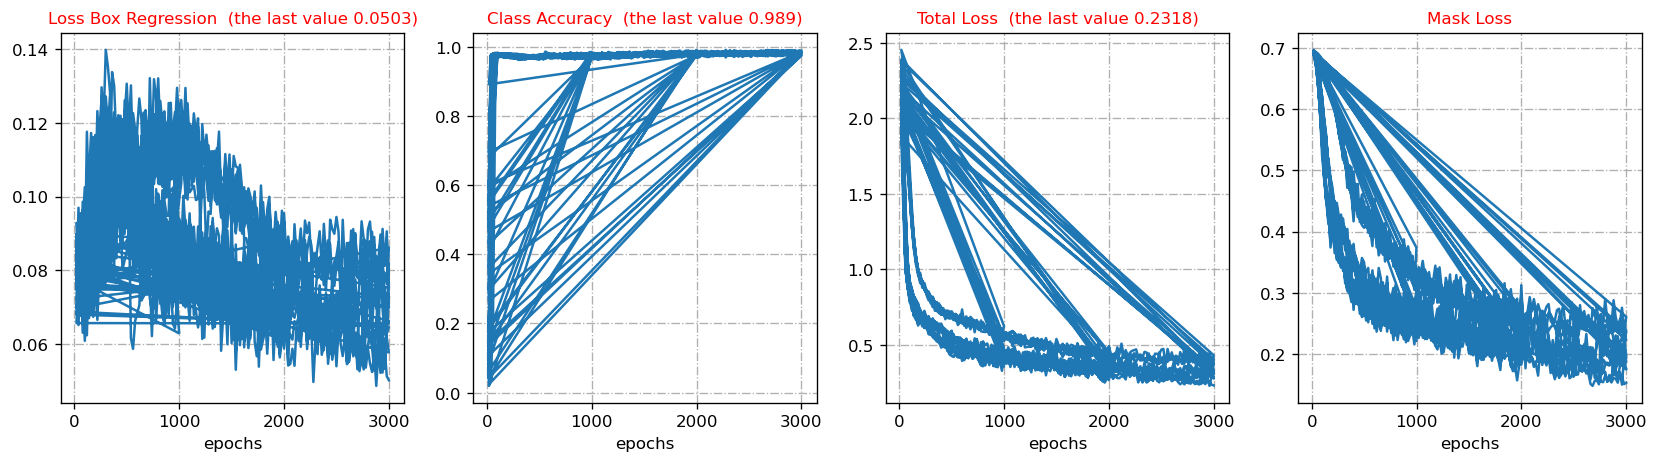

In [10]:
train_metrics = read_metrics_from_json('./output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
loss_mask = metric(train_metrics, 'loss_mask')
loss_box_reg = metric(train_metrics, 'loss_box_reg')


# checking metric lengths
if len(iters) == len(total_loss) == len(cls_acc) == len(loss_mask) == len(loss_box_reg):
    pass
else:
    iters = iters[:-1]

fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)


axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, loss_mask)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('Mask Loss', fontsize = 10, color = 'red')

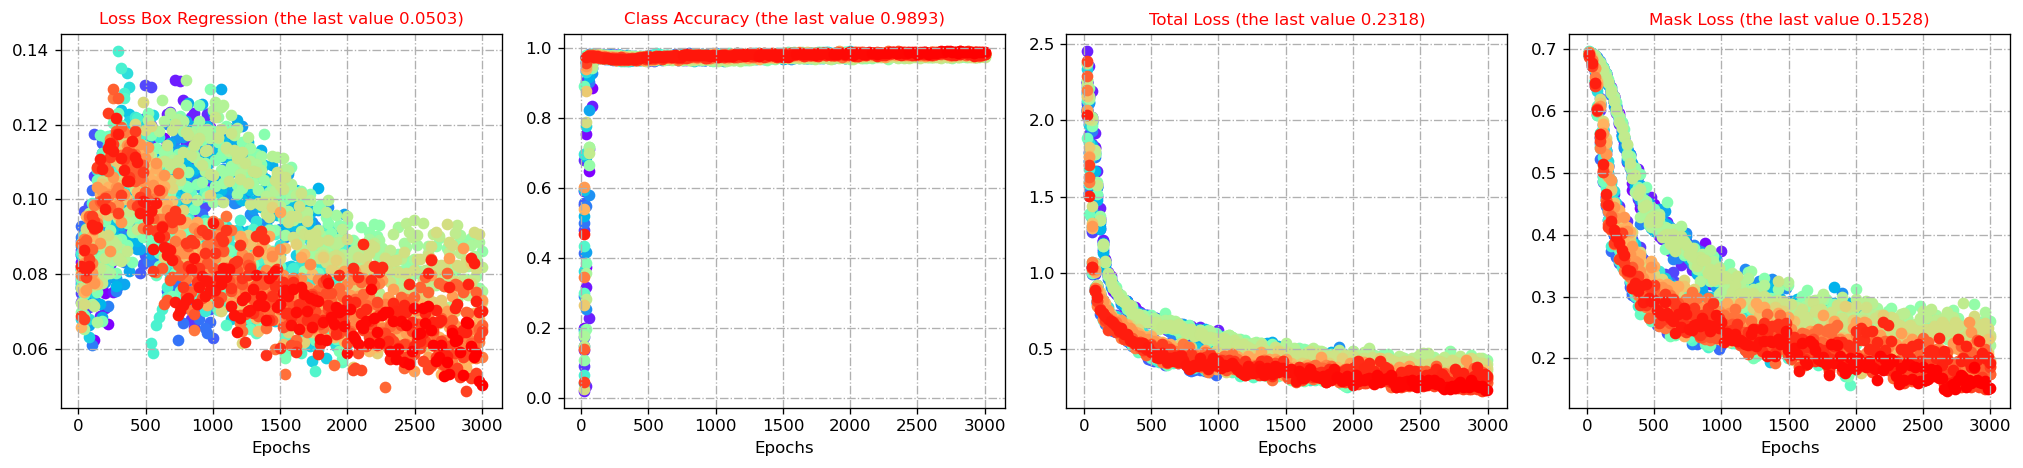

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import json

def read_metrics_from_json(file_path):
    metrics = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                metrics.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from line: {e}")
    return metrics

def extract_metric(metrics, key):
    return [m.get(key, float('nan')) for m in metrics if key in m]

train_metrics = read_metrics_from_json('./output/metrics.json')

iters = extract_metric(train_metrics, 'iteration')
total_loss = extract_metric(train_metrics, 'total_loss')
cls_acc = extract_metric(train_metrics, 'fast_rcnn/cls_accuracy')
loss_mask = extract_metric(train_metrics, 'loss_mask')
loss_box_reg = extract_metric(train_metrics, 'loss_box_reg')

min_length = min(len(iters), len(total_loss), len(cls_acc), len(loss_mask), len(loss_box_reg))
iters = iters[:min_length]
total_loss = total_loss[:min_length]
cls_acc = cls_acc[:min_length]
loss_mask = loss_mask[:min_length]
loss_box_reg = loss_box_reg[:min_length]

fig, axs = plt.subplots(1, 4, figsize=(17, 4), dpi=120)
metrics = [loss_box_reg, cls_acc, total_loss, loss_mask]
titles = ['Loss Box Regression', 'Class Accuracy', 'Total Loss', 'Mask Loss']

# Generate colors from a colormap
colors = cm.rainbow(np.linspace(0, 1, min_length))

for ax, metric, title in zip(axs, metrics, titles):
    ax.grid(linestyle='dashdot')
    for i, color in zip(range(min_length), colors):
        ax.scatter(iters[i], metric[i], color=color)
    ax.set_xlabel('Epochs', fontsize=10)
    last_value = metric[-1]
    ax.set_title(f'{title} (the last value {last_value:.4f})', fontsize=10, color='red')

plt.tight_layout()
plt.show()


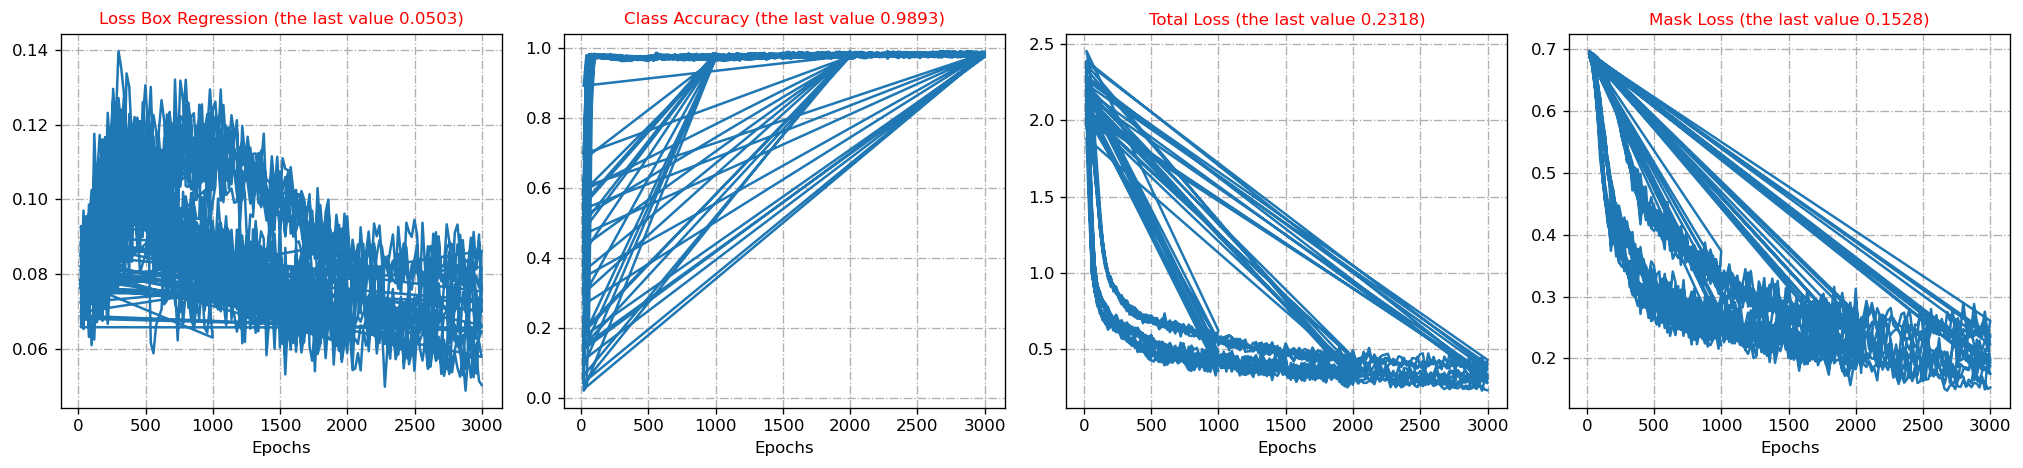

In [11]:
import matplotlib.pyplot as plt


train_metrics = read_metrics_from_json('./output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
loss_mask = metric(train_metrics, 'loss_mask')
loss_box_reg = metric(train_metrics, 'loss_box_reg')

# Align all arrays to the same length based on the shortest array
min_length = min(len(iters), len(total_loss), len(cls_acc), len(loss_mask), len(loss_box_reg))
iters = iters[:min_length]
total_loss = total_loss[:min_length]
cls_acc = cls_acc[:min_length]
loss_mask = loss_mask[:min_length]
loss_box_reg = loss_box_reg[:min_length]

fig, axs = plt.subplots(1, 4, figsize=(17, 4), dpi=120)

titles = ['Loss Box Regression', 'Class Accuracy', 'Total Loss', 'Mask Loss']
metrics = [loss_box_reg, cls_acc, total_loss, loss_mask]

for i, metric in enumerate(metrics):
    axs[i].grid(linestyle='dashdot')
    axs[i].plot(iters, metric)
    axs[i].set_xlabel('Epochs', fontsize=10)
    title = f"{titles[i]} (the last value {metric[-1]:.4f})"
    axs[i].set_title(title, fontsize=10, color='red')

plt.tight_layout()
plt.show()


/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

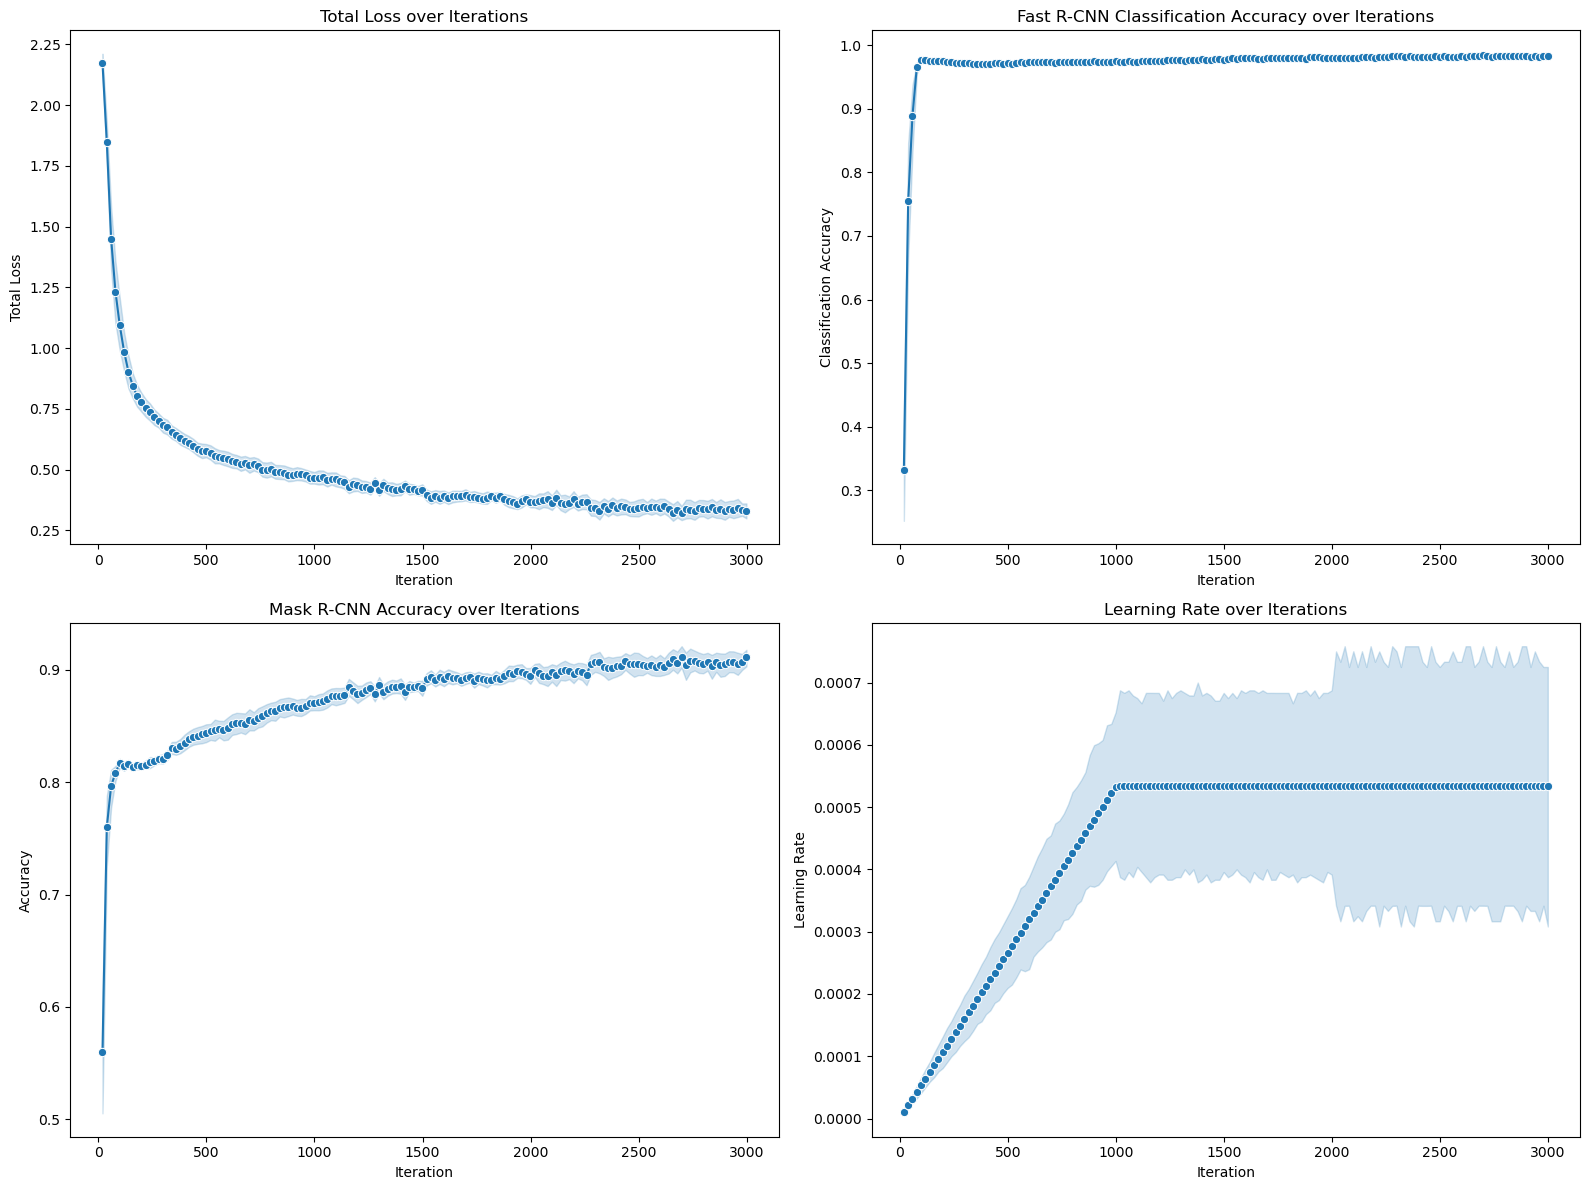

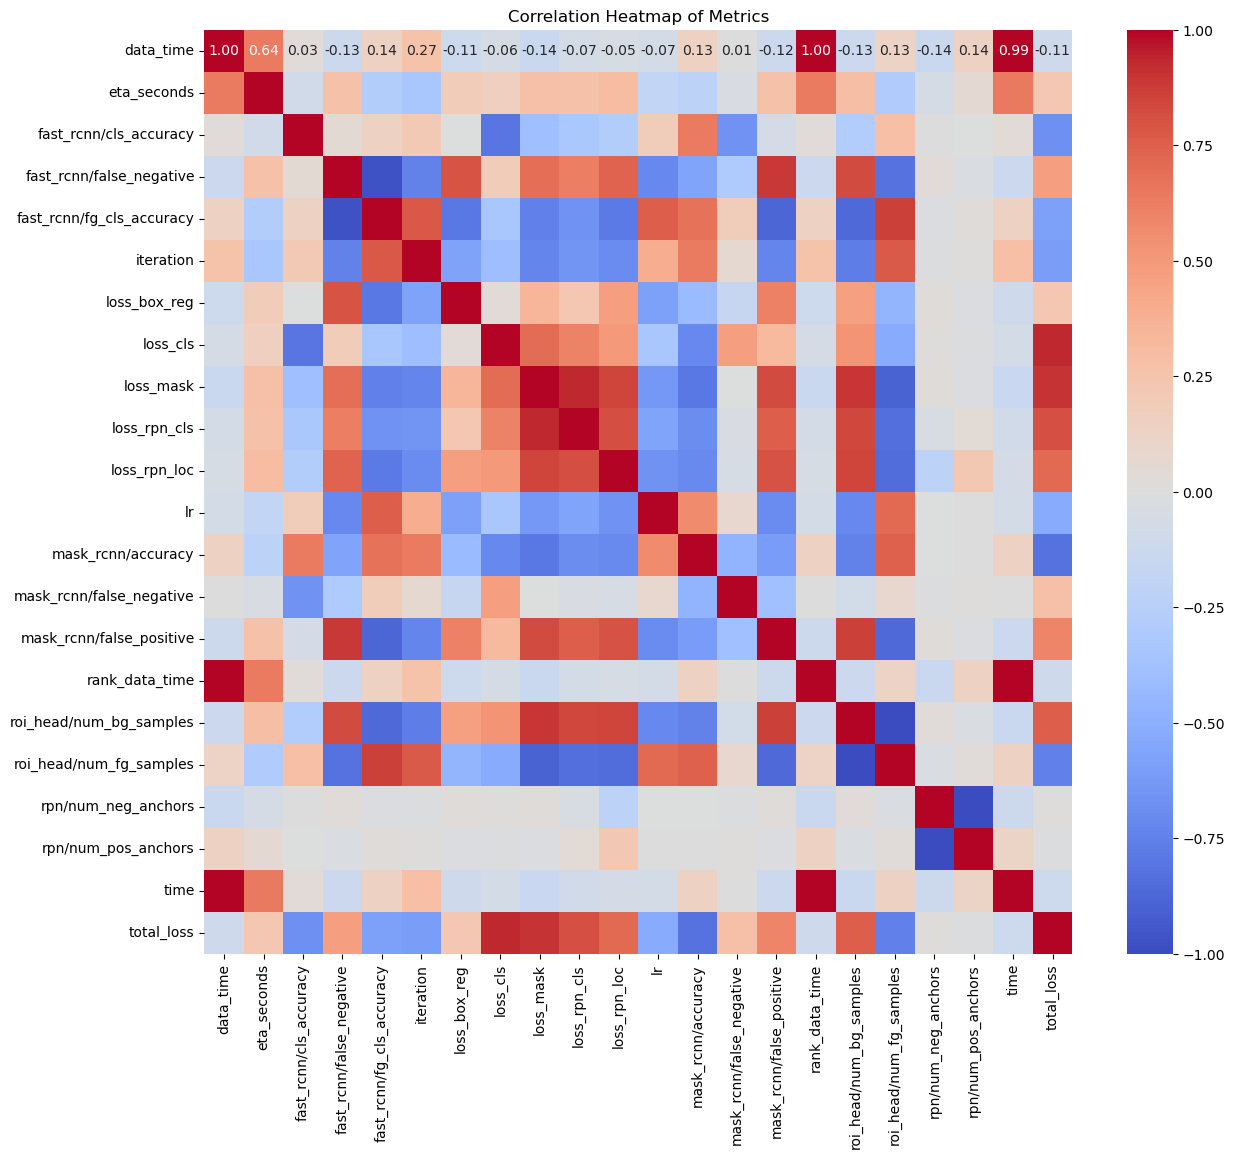

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = './output/metrics.json'
with open(file_path, 'r') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

# Plotting trends of key metrics over iterations
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

# Total Loss
sns.lineplot(data=df, x="iteration", y="total_loss", ax=axes[0], marker="o")
axes[0].set_title("Total Loss over Iterations")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Total Loss")

# Fast R-CNN Classification Accuracy
sns.lineplot(data=df, x="iteration", y="fast_rcnn/cls_accuracy", ax=axes[1], marker="o")
axes[1].set_title("Fast R-CNN Classification Accuracy over Iterations")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Classification Accuracy")

# Mask R-CNN Accuracy
sns.lineplot(data=df, x="iteration", y="mask_rcnn/accuracy", ax=axes[2], marker="o")
axes[2].set_title("Mask R-CNN Accuracy over Iterations")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Accuracy")

# Learning Rate
sns.lineplot(data=df, x="iteration", y="lr", ax=axes[3], marker="o")
axes[3].set_title("Learning Rate over Iterations")
axes[3].set_xlabel("Iteration")
axes[3].set_ylabel("Learning Rate")

plt.tight_layout()
plt.show()

# Calculating correlation matrix
correlation_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Metrics")
plt.show()



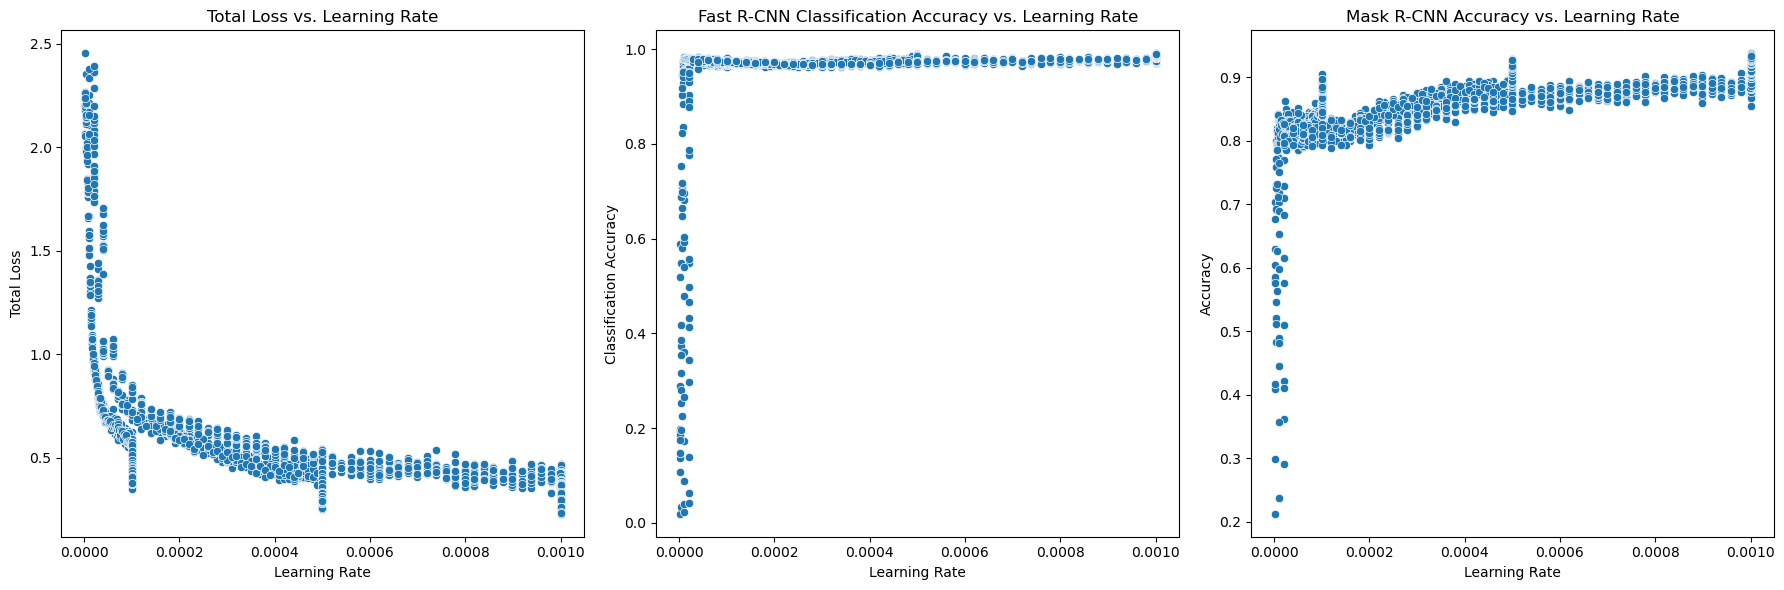

/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

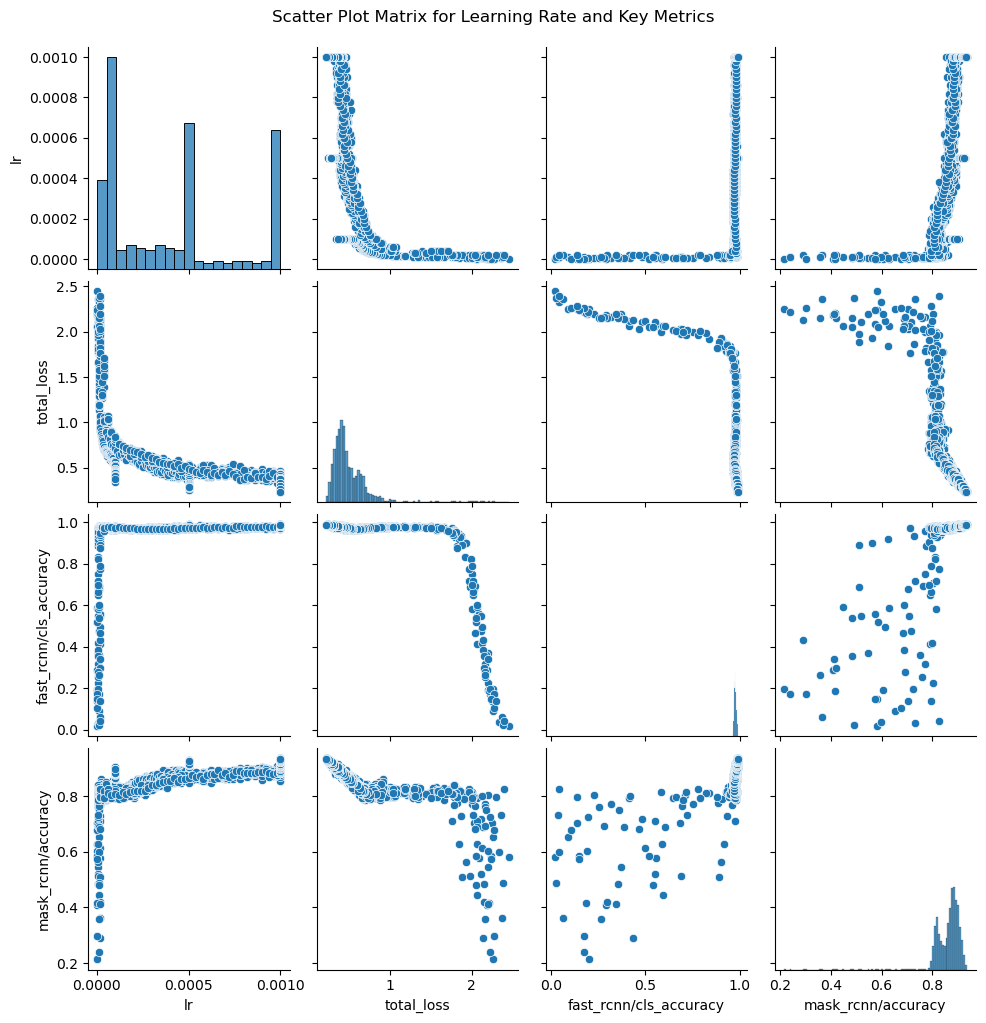

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Total Loss vs. Learning Rate
sns.scatterplot(data=df, x="lr", y="total_loss", ax=axes[0])
axes[0].set_title("Total Loss vs. Learning Rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Total Loss")

# Fast R-CNN Classification Accuracy vs. Learning Rate
sns.scatterplot(data=df, x="lr", y="fast_rcnn/cls_accuracy", ax=axes[1])
axes[1].set_title("Fast R-CNN Classification Accuracy vs. Learning Rate")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Classification Accuracy")

# Mask R-CNN Accuracy vs. Learning Rate
sns.scatterplot(data=df, x="lr", y="mask_rcnn/accuracy", ax=axes[2])
axes[2].set_title("Mask R-CNN Accuracy vs. Learning Rate")
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Selecting a subset of columns for the scatter plot matrix
columns_for_spm = ["lr", "total_loss", "fast_rcnn/cls_accuracy", "mask_rcnn/accuracy"]

# Creating a scatter plot matrix
sns.pairplot(df[columns_for_spm])
plt.suptitle("Scatter Plot Matrix for Learning Rate and Key Metrics", y=1.02) # Adjust title position
plt.show()


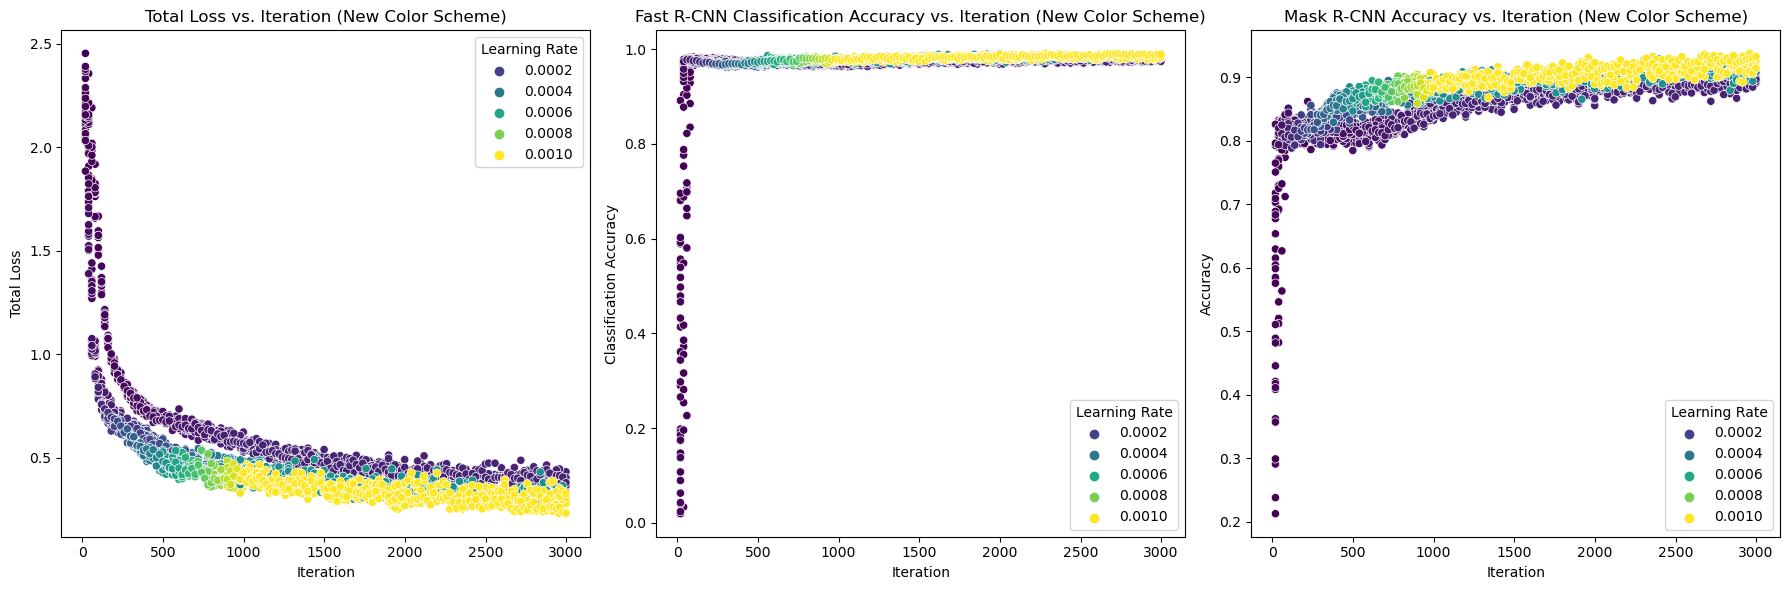

In [4]:
plt.figure(figsize=(18, 6))

# Setting the color map to visualize the learning rate values with a new scheme
cmap_new = sns.color_palette("viridis", as_cmap=True)

# Plotting Total Loss vs. Iteration with the new color scheme
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x="iteration", y="total_loss", hue="lr", palette=cmap_new)
plt.title("Total Loss vs. Iteration (New Color Scheme)")
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.legend(title='Learning Rate', loc='upper right', ncol=1)

# Plotting Fast R-CNN Classification Accuracy vs. Iteration with the new color scheme
plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x="iteration", y="fast_rcnn/cls_accuracy", hue="lr", palette=cmap_new)
plt.title("Fast R-CNN Classification Accuracy vs. Iteration (New Color Scheme)")
plt.xlabel("Iteration")
plt.ylabel("Classification Accuracy")
plt.legend(title='Learning Rate', loc='lower right', ncol=1)

# Plotting Mask R-CNN Accuracy vs. Iteration with the new color scheme
plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x="iteration", y="mask_rcnn/accuracy", hue="lr", palette=cmap_new)
plt.title("Mask R-CNN Accuracy vs. Iteration (New Color Scheme)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(title='Learning Rate', loc='lower right', ncol=1)

plt.tight_layout()
plt.show()


/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/atesfet/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

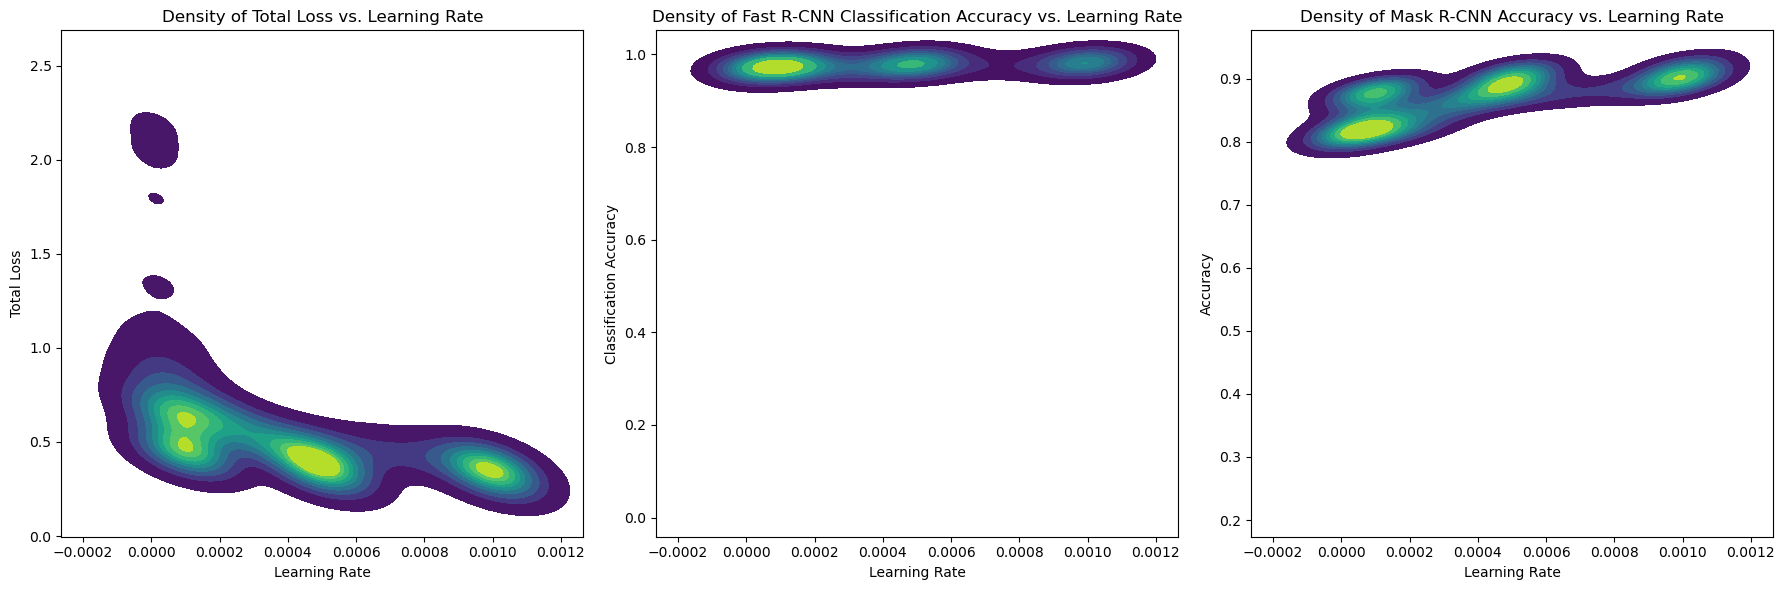

In [5]:
import numpy as np

# Creating density plots for learning rate against key metrics
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Total Loss
sns.kdeplot(data=df, x="lr", y="total_loss", ax=axes[0], cmap="viridis", fill=True)
axes[0].set_title("Density of Total Loss vs. Learning Rate")
axes[0].set_xlabel("Learning Rate")
axes[0].set_ylabel("Total Loss")

# Fast R-CNN Classification Accuracy
sns.kdeplot(data=df, x="lr", y="fast_rcnn/cls_accuracy", ax=axes[1], cmap="viridis", fill=True)
axes[1].set_title("Density of Fast R-CNN Classification Accuracy vs. Learning Rate")
axes[1].set_xlabel("Learning Rate")
axes[1].set_ylabel("Classification Accuracy")

# Mask R-CNN Accuracy
sns.kdeplot(data=df, x="lr", y="mask_rcnn/accuracy", ax=axes[2], cmap="viridis", fill=True)
axes[2].set_title("Density of Mask R-CNN Accuracy vs. Learning Rate")
axes[2].set_xlabel("Learning Rate")
axes[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


### Working With an Already Trained Model

In [ ]:
# Comment below if training new model (might not be necessary)
with open("cfg.pkl", "rb") as f:
    cfg = pickle.load(f)

trainer = DefaultTrainer(cfg) 
predictor = DefaultPredictor(cfg)
trainer.resume_or_load(resume=True)

### Prediction on the Validation Set

In [ ]:
# Predict validation set
evaluator = COCOEvaluator("valid_set", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "valid_set")
inference_on_dataset(trainer.model, test_loader, evaluator)

### Visualization of Results

In [ ]:
valid_metadata = MetadataCatalog.get("valid_set")
valid_dicts = DatasetCatalog.get("valid_set")

create_predictions(valid_dicts, valid_metadata, predictor, image_scale = 1)
create_predictions(valid_dicts, valid_metadata, predictor, image_scale = 1)

## Performance Metrics Logging with TensorBoard

In [ ]:

# Setup TensorBoard for Detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Ensure the OUTPUT_DIR is set in your Detectron2 config to log metrics
# You can view logs in TensorBoard by running it in the OUTPUT_DIR
# Example: tensorboard --logdir output
